# **Remove/Pick up electric? noise**
If you apply fourier transform to clean data, you'll found additional periodic noise.  
This may be a important feature. I introduce a way to treat this noise.  
I don't know how it would affect the prediction. If you have verified, Teach me!  
(I found the word "Kalman filter" several times, is it related?)
  
Thanks to Chris Deotte for [clean data](https://www.kaggle.com/cdeotte/data-without-drift)!

 **! <span style="color: red; ">I changed function "bandpass" and "bandstop". The instructions are in the comments. </span>! **

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import os.path as path
import numpy.fft as fft
from scipy import signal as scisig
from sklearn.linear_model import LinearRegression

# **Preprocessing** (useing clean data)

In [0]:
dataset_path = path.join("./drive/My Drive/Colab Notebooks/liverpool-ion-switching/data")
csv_name = "train_clean_kalman_batch7_gause.csv"
train = read_csv(path.join(dataset_path, csv_name))
time = train["time"].values
signal = train["signal"].values
channels = train["open_channels"].values

In [0]:
# Apart 2 type

signalA = np.hstack((signal[:2000000], signal[2500000:4000000], signal[4000000:4500000]))
channelsA = np.hstack((channels[:2000000], channels[2500000:4000000], channels[4000000:4500000]))
# Fill odd value to median
signal1 = signal[:1000000]
channels1 = channels[:1000000]
median = np.median(signal1[channels1 == 0])
condition = (signal1 > -1) & (channels1 == 0)
signal1[condition] = median
signalA[:1000000] = signal1


signalB = np.hstack((signal[2000000:2500000], signal[4500000:]))
channelsB = np.hstack((channels[2000000:2500000], channels[4500000:]))

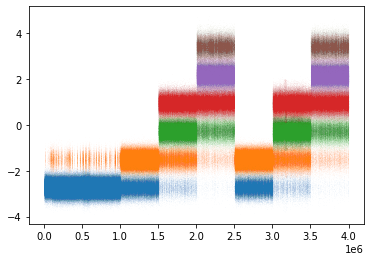

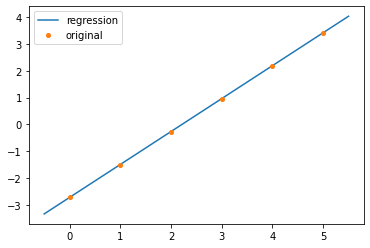

meanA : [-2.72788201 -1.49846783 -0.26905364  0.96036054  2.18977473  3.41918891]


In [17]:
# Visual data (type A)

signal = signalA
channels = channelsA

c = 6   # channel size
label = np.arange(len(signal))

channel_list = np.arange(c)
n_list = np.empty(c)
mean_list = np.empty(c)
std_list = np.empty(c)
stderr_list = np.empty(c)

for i in range(c):
    x = label[channels == i]
    y = signal[channels == i]
    n_list[i] = np.size(y)
    mean_list[i] = np.mean(y)
    std_list[i] = np.std(y)
    plt.plot(x, y, ".", markersize = 0.5, alpha = 0.02)
    
stderr_list = std_list / np.sqrt(n_list)
plt.show()


# Predict general mean

w = 1 / stderr_list
channel_list = channel_list.reshape(-1, 1)
linreg_m = LinearRegression()
linreg_m.fit(channel_list, mean_list, sample_weight = w)

mean_predictA = linreg_m.predict(channel_list)

x = np.linspace(-0.5, 5.5, 5)
y = linreg_m.predict(x.reshape(-1, 1))
plt.plot(x, y, label = "regression")
plt.plot(channel_list, mean_list, ".", markersize = 8, label = "original")
plt.legend()
plt.show()

print("meanA :", mean_predictA)

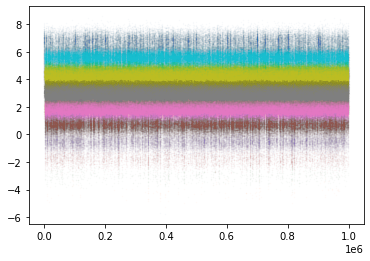

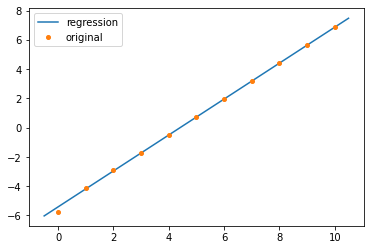

meanB : [-5.41787339 -4.19032941 -2.96278543 -1.73524145 -0.50769747  0.71984651
  1.94739049  3.17493447  4.40247844  5.63002242  6.8575664 ]


In [18]:
# Visual data (type B)

signal = signalB
channels = channelsB
label = np.arange(len(channels))

c = 11   # channel size

channel_list = np.arange(c)
n_list = np.empty(c)
mean_list = np.empty(c)
std_list = np.empty(c)
stderr_list = np.empty(c)

for i in range(c):
    x = label[channels == i]
    y = signal[channels == i]
    n_list[i] = np.size(y)
    mean_list[i] = np.mean(y)
    std_list[i] = np.std(y)
    plt.plot(x, y, ".", markersize = 0.7, alpha = 0.03)
    
stderr_list = std_list / np.sqrt(n_list)
plt.show()


# Predict general mean

w = 1 / stderr_list
channel_list = channel_list.reshape(-1, 1)
linreg_m = LinearRegression()
linreg_m.fit(channel_list, mean_list, sample_weight = w)

mean_predictB = linreg_m.predict(channel_list)

x = np.linspace(-0.5, 10.5, 5)
y = linreg_m.predict(x.reshape(-1, 1))
plt.plot(x, y, label = "regression")
plt.plot(channel_list, mean_list, ".", markersize = 8, label = "original")
plt.legend()
plt.show()

print("meanB :", mean_predictB)

In [0]:
def Arrange_mean(signal, channels, diff, channel_range):
    signal_out = signal.copy()
    for i in range(channel_range):
        signal_out[channels == i] -= diff[i]
    return signal_out

def bandstop(x, samplerate = 1000000, fp = np.array([4925, 5075]), fs = np.array([4800, 5200])):
    fn = samplerate / 2   # Nyquist frequency
    wp = fp / fn
    ws = fs / fn
    gpass = 1
    gstop = 10.0

    N, Wn = scisig.buttord(wp, ws, gpass, gstop)
    b, a = scisig.butter(N, Wn, "bandstop")
    y = scisig.filtfilt(b, a, x)
    return y

def bandpass(x, samplerate = 1000000, fp = np.array([4925, 5075]), fs = np.array([4800, 5200])):
    fn = samplerate / 2   # Nyquist frequency
    wp = fp / fn
    ws = fs / fn
    gpass = 1
    gstop = 10.0

    N, Wn = scisig.buttord(wp, ws, gpass, gstop)
    b, a = scisig.butter(N, Wn, "bandpass")
    y = scisig.filtfilt(b, a, x)
    return y

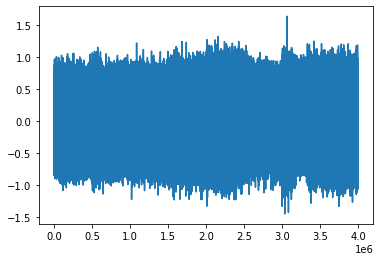

In [20]:
sig_A = Arrange_mean(signalA, channelsA, mean_predictA, 6)
plt.plot(sig_A)
plt.show()

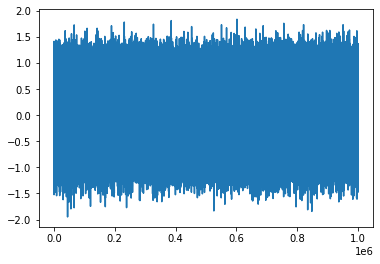

In [21]:
sig_B = Arrange_mean(signalB, channelsB, mean_predictB, 11)
plt.plot(sig_B)
plt.show()

# **Fourier transform**
This data has periodic noise in addition to the gaussian noise

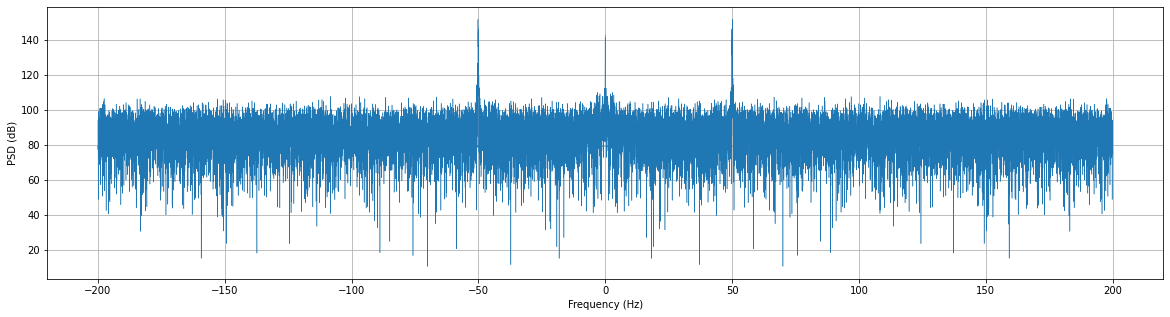

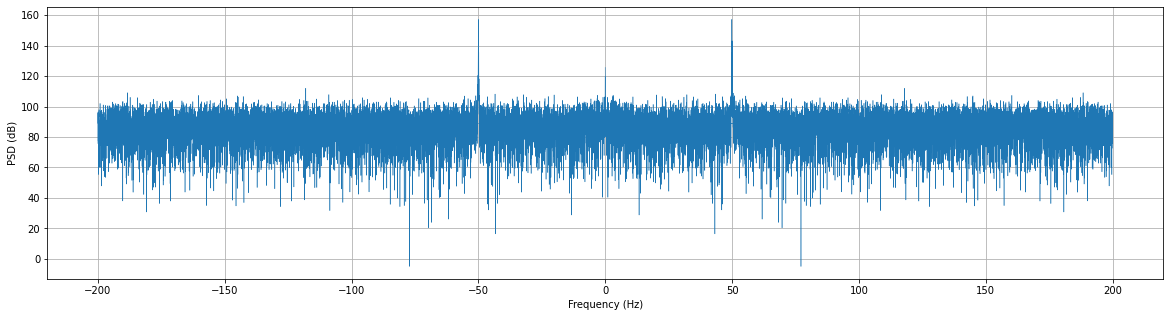

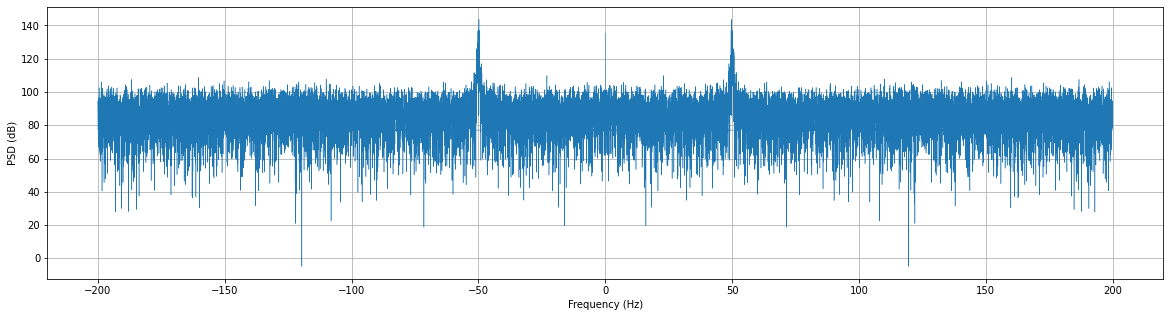

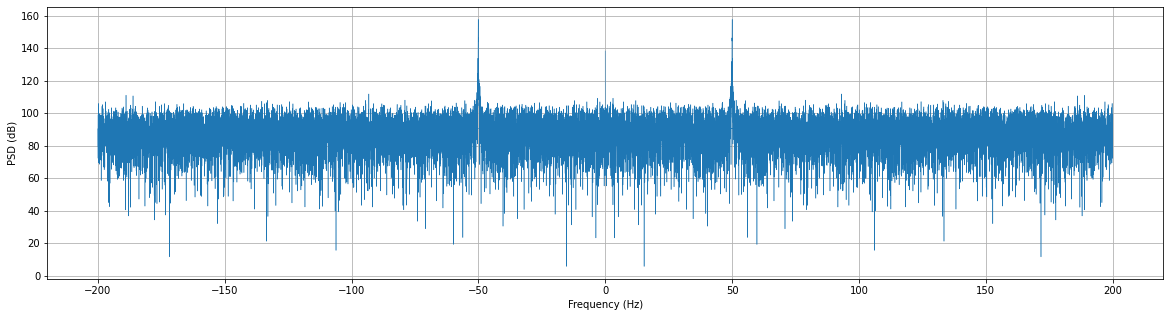

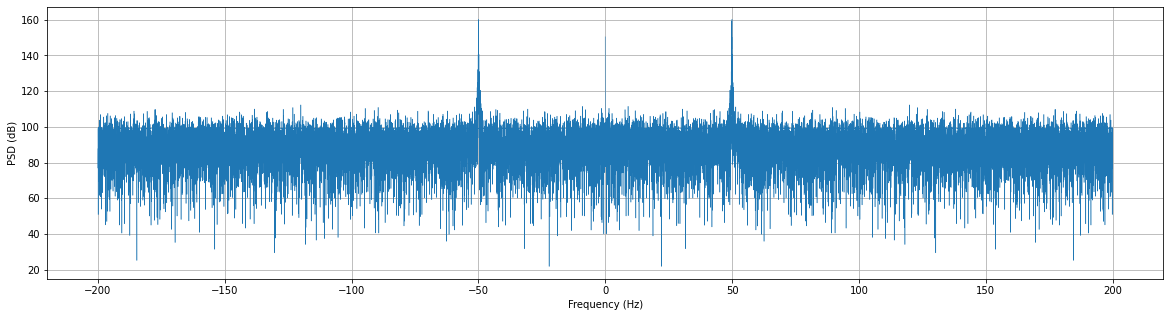

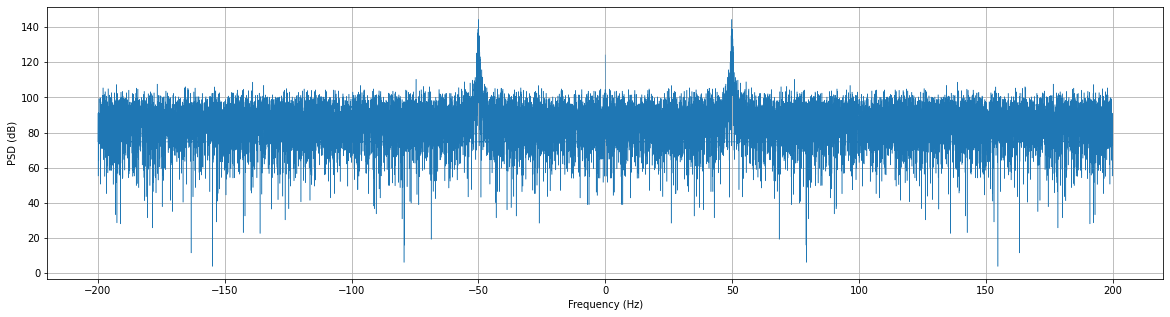

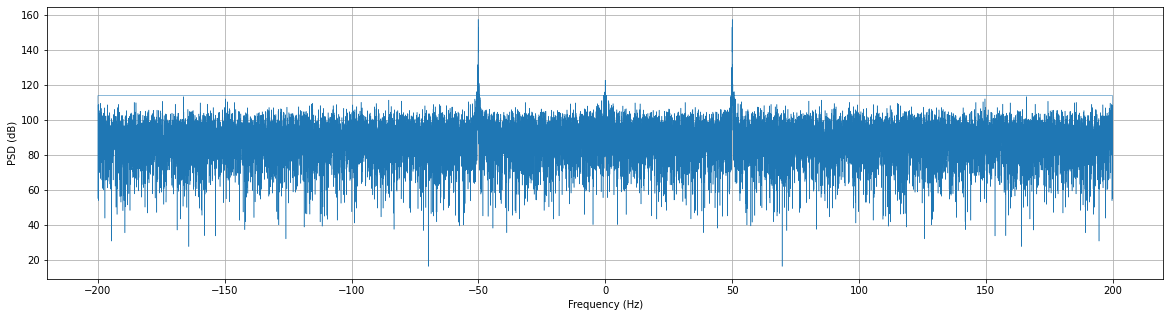

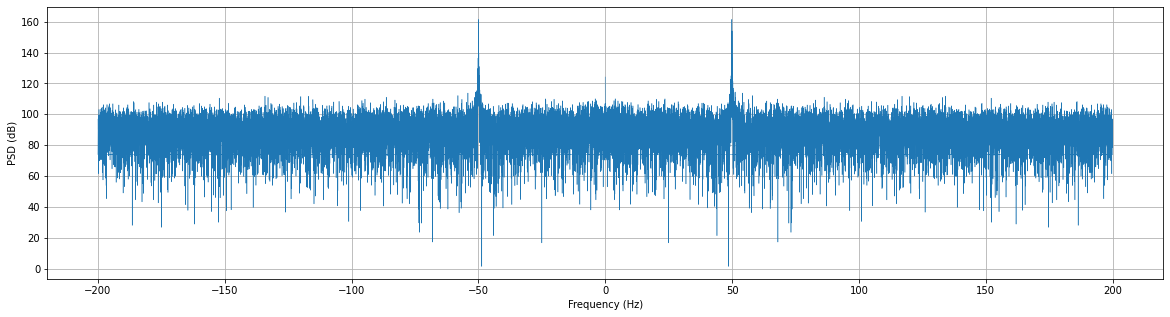

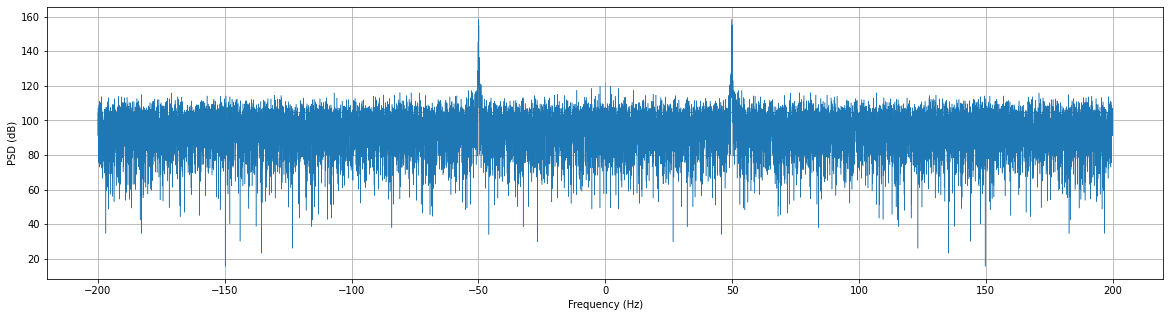

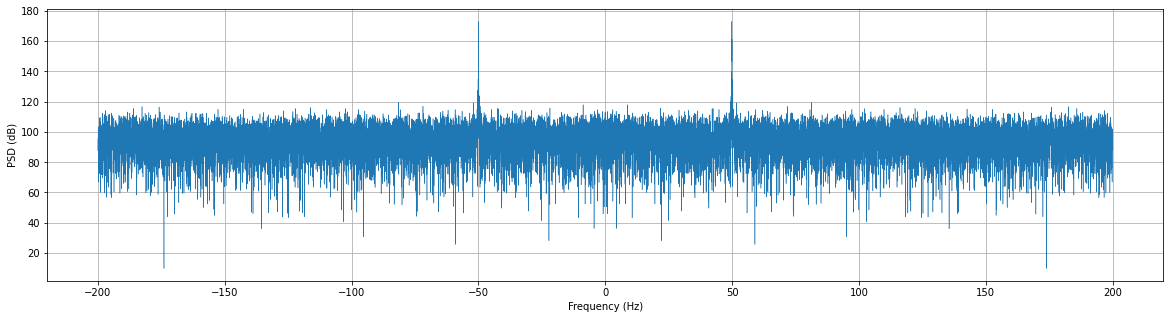

In [22]:
signal_flat = np.hstack((sig_A, sig_B))
sig_list = np.split(signal_flat, 10)
fs=10000.
for sig_sample in sig_list:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
    fig.subplots_adjust(hspace = .5)

    fft = np.fft.fft(sig_sample)
    psd = np.abs(fft) ** 2
    fftfreq = np.fft.fftfreq(len(psd),1/fs)
    
    i = abs(fftfreq) < 200
    ax.grid()
    ax.plot(fftfreq[i], 20*np.log10(psd[i]), linewidth=.5)
    ax.set_xlabel('Frequency (Hz)') 
    ax.set_ylabel('PSD (dB)')
    plt.show()

# **Remove noise by Bandstop filter**

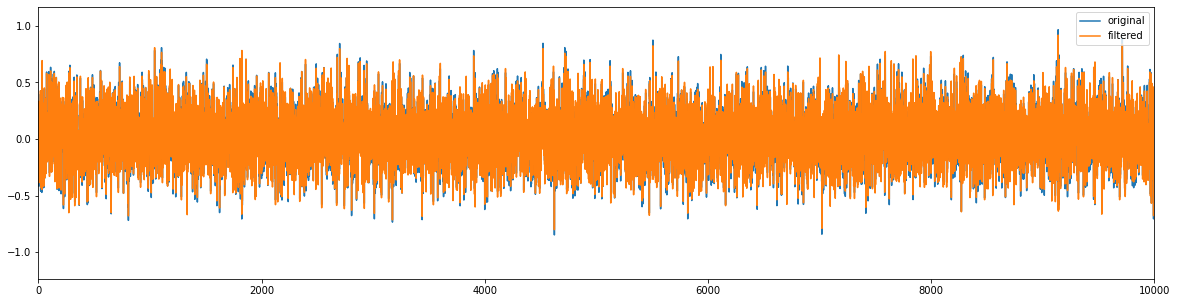

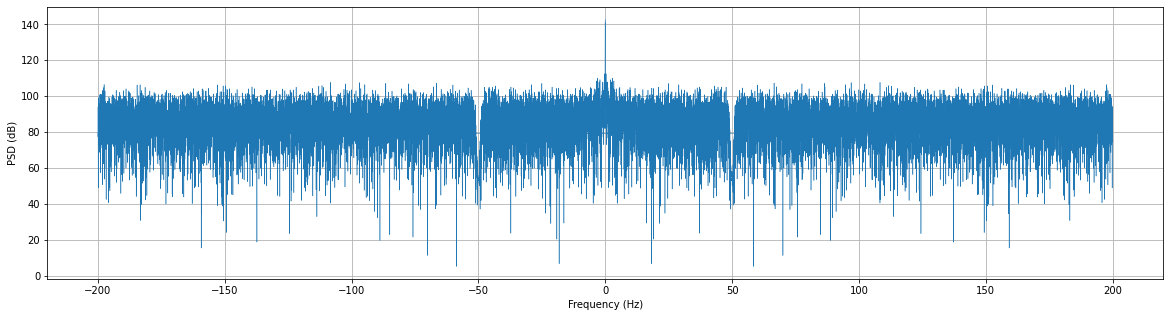

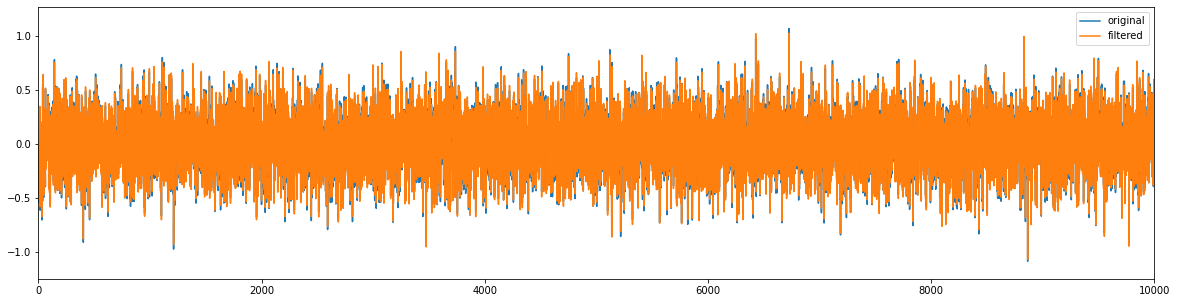

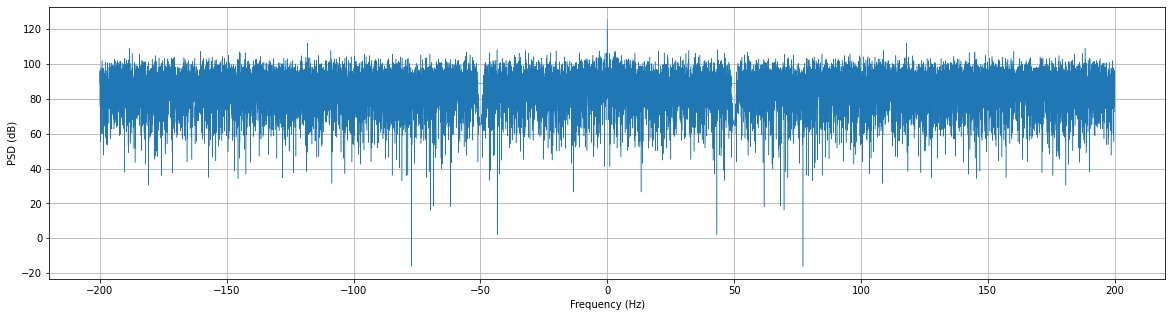

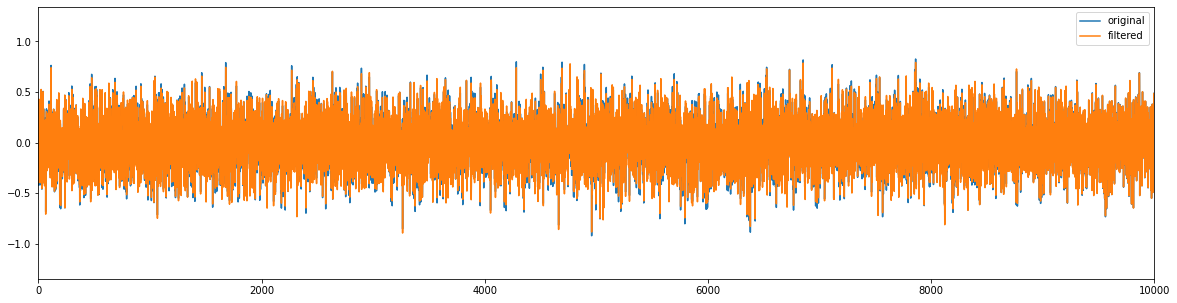

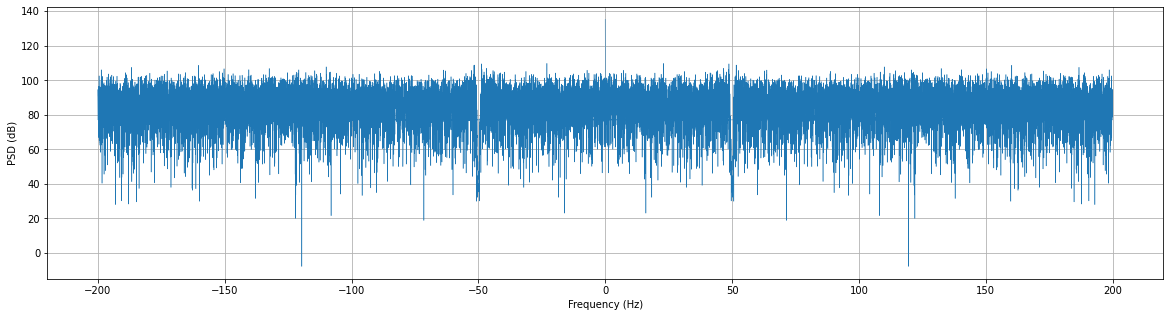

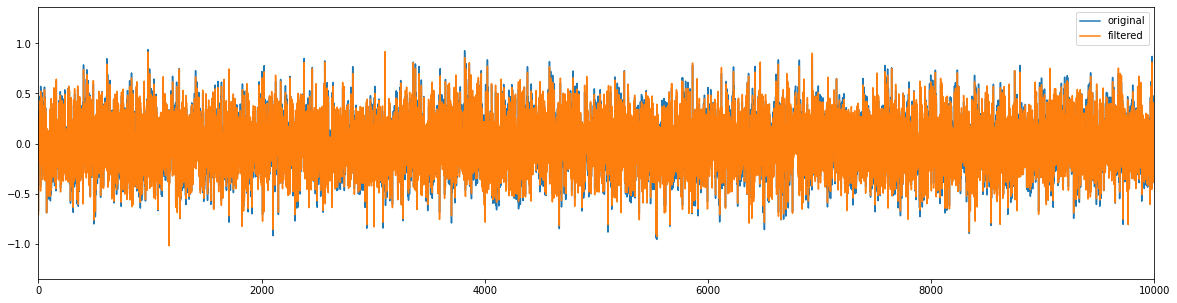

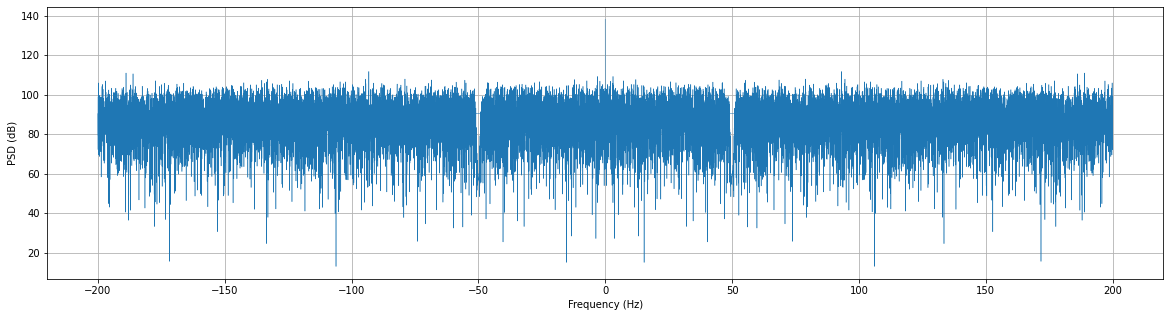

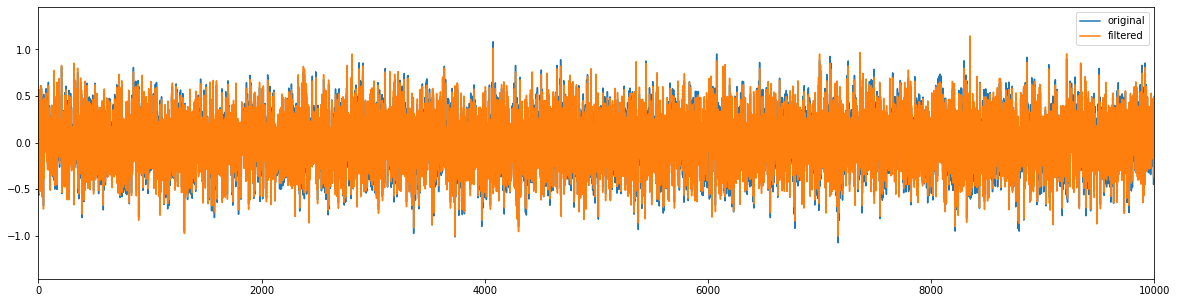

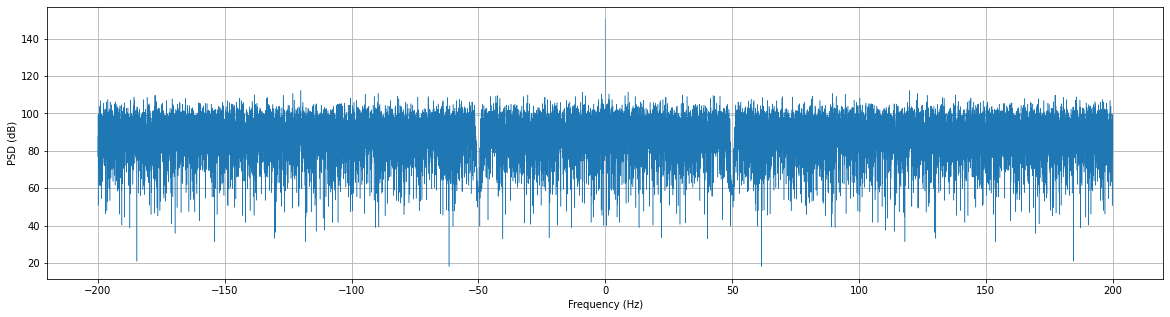

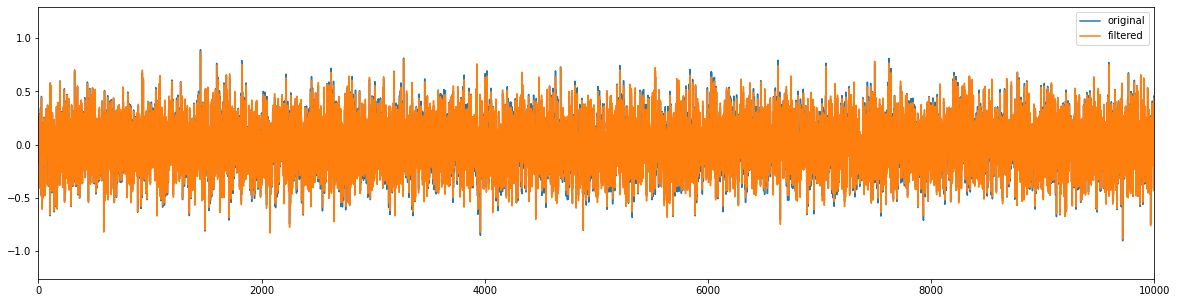

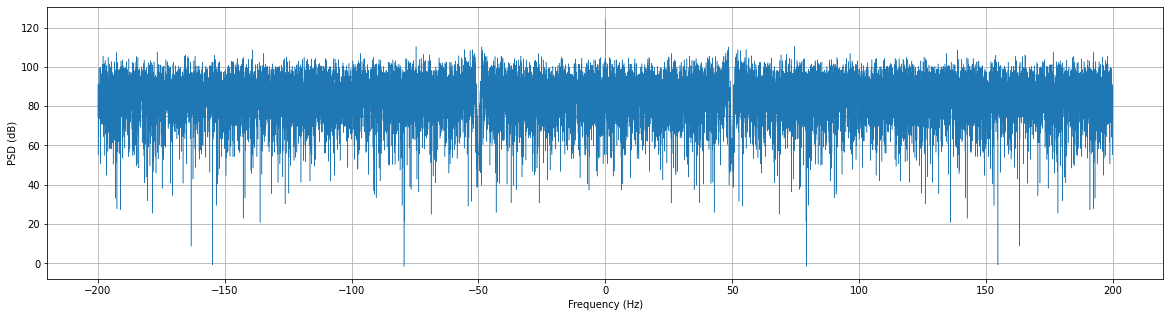

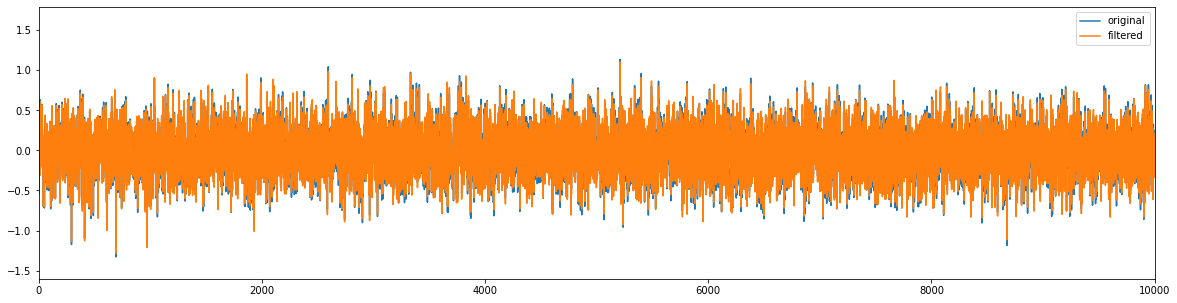

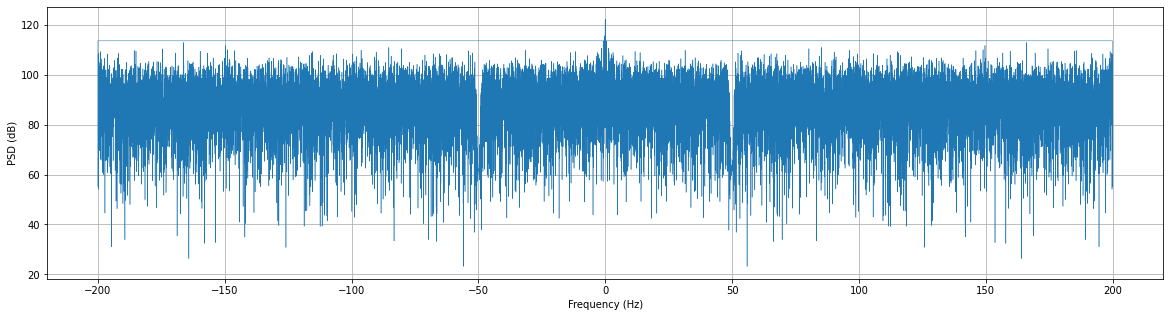

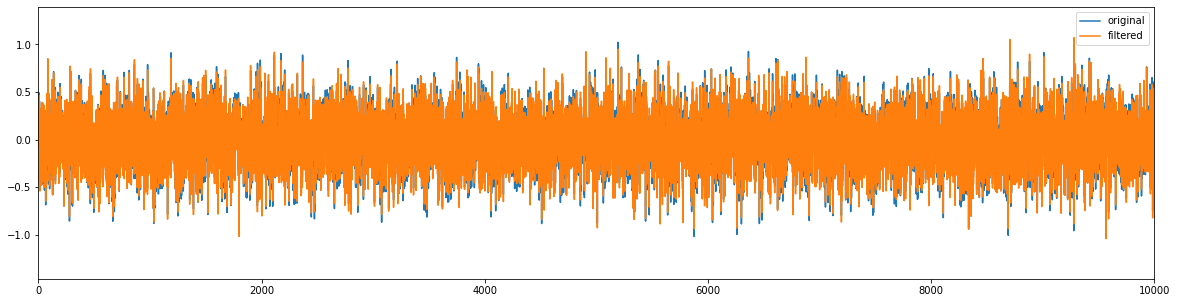

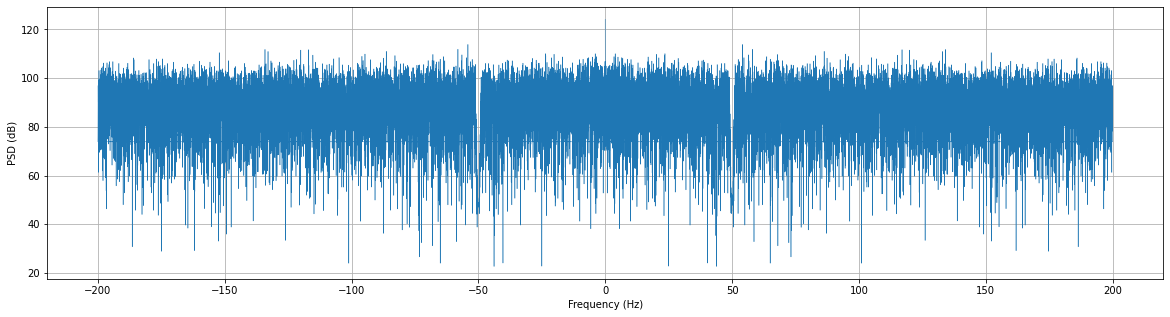

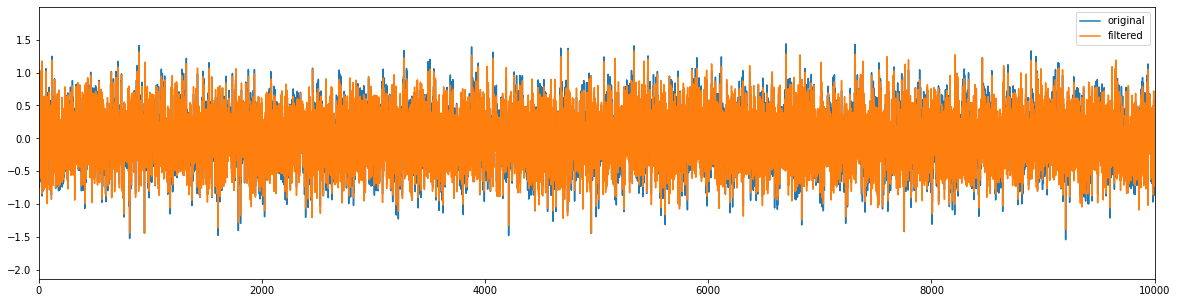

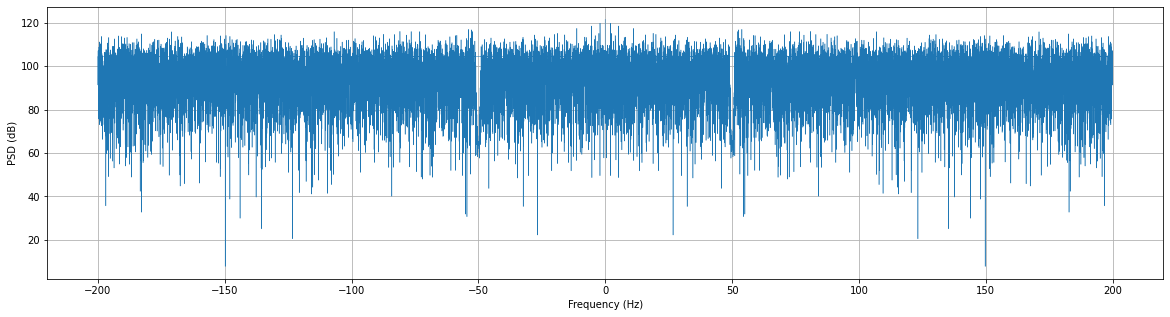

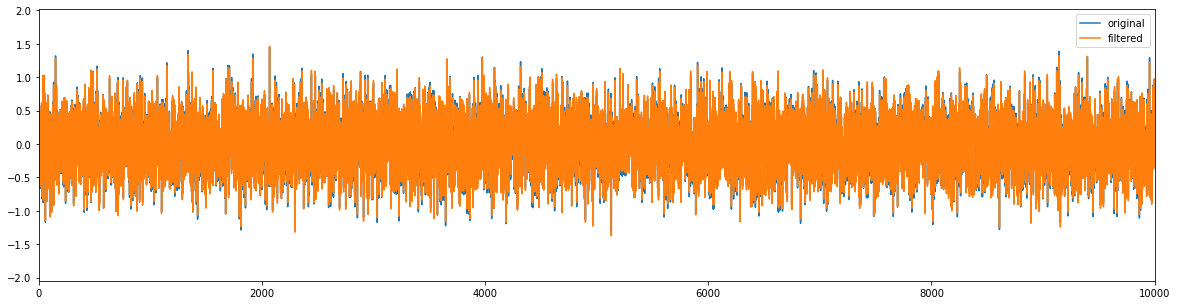

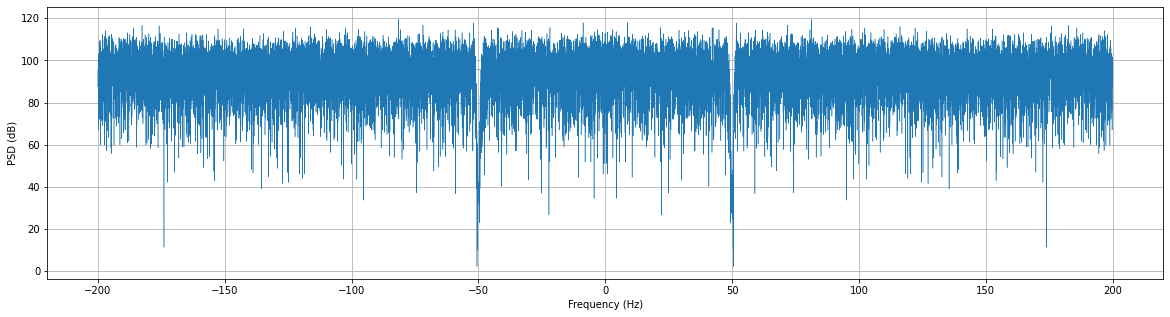

In [23]:
sig_removes = []

for sig_sample in sig_list:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
    fig.subplots_adjust(hspace = .5)
    sig_remove = bandstop(sig_sample)
    sig_removes.extend(sig_remove)
    ax.plot(sig_sample, label = "original")
    ax.plot(sig_remove, label = "filtered")
    ax.legend(loc = "upper right")
    ax.set_xlim(0, 10000)
    plt.show()
    
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
    fig.subplots_adjust(hspace = .5)
    fft = np.fft.fft(sig_remove)
    psd = np.abs(fft) ** 2
    fftfreq = np.fft.fftfreq(len(psd),1/fs)
    
    i = abs(fftfreq) < 200
    ax.grid()
    ax.plot(fftfreq[i], 20*np.log10(psd[i]), linewidth=.5)
    ax.set_xlabel('Frequency (Hz)') 
    ax.set_ylabel('PSD (dB)')
    plt.show()

In [0]:
len(sig_removes)

sig_removes_sort = [0] * 5000000
sig_removes_sort[:2000000] = sig_removes[:2000000]
sig_removes_sort[2000000:2500000] = sig_removes[4000000:4500000]
sig_removes_sort[2500000:4000000] = sig_removes[2000000:3500000]
sig_removes_sort[4000000:4500000] = sig_removes[3500000:4000000]
sig_removes_sort[4500000:5000000] = sig_removes[4500000:5000000]

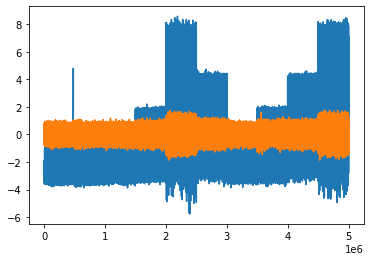

In [25]:
csv_name = "train_clean_kalman_batch7_gause.csv"
train_ = read_csv(path.join(dataset_path, csv_name))
plt.plot(train_['signal'])
train_['signal'] = sig_removes_sort
train_.to_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/train_clean_kalman_batch7_gause_rem_noise.csv', index=False)
plt.plot(train_['signal'])

# **Pick up noise by Bandpass filter**

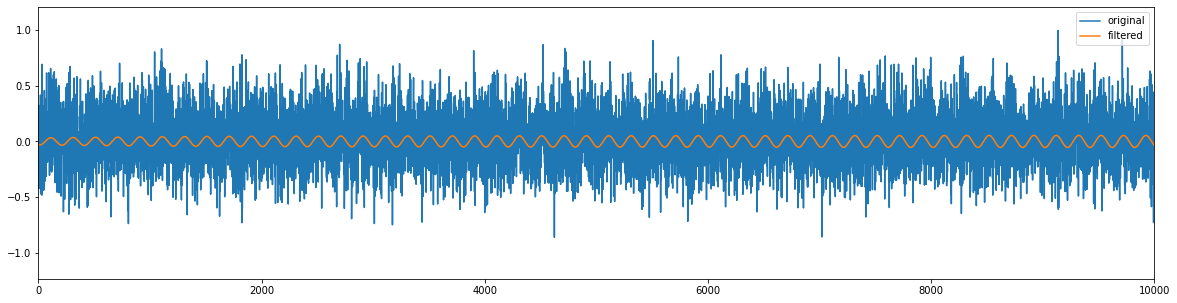

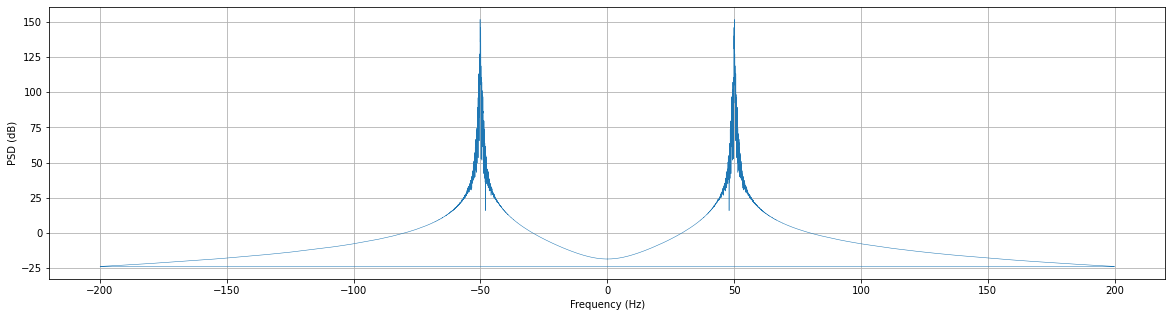

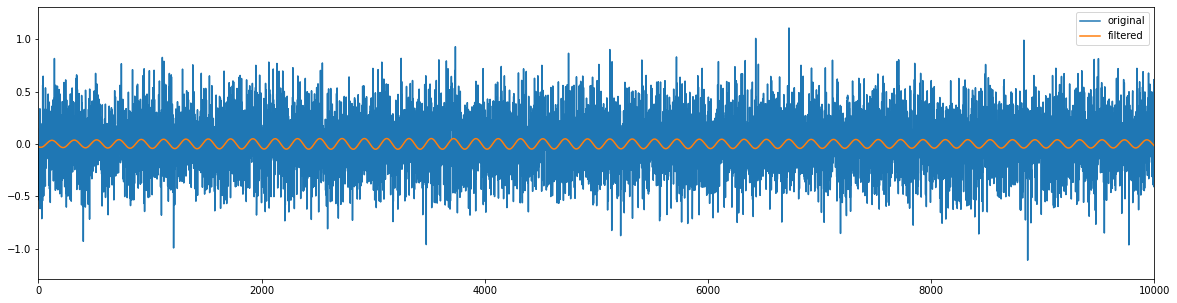

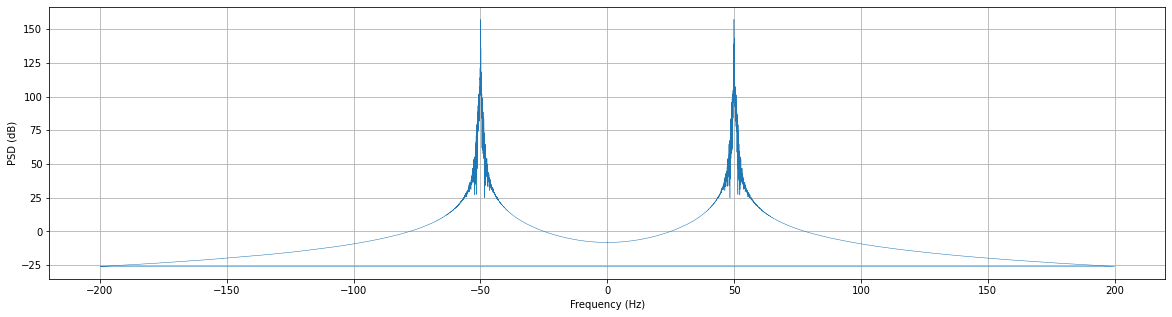

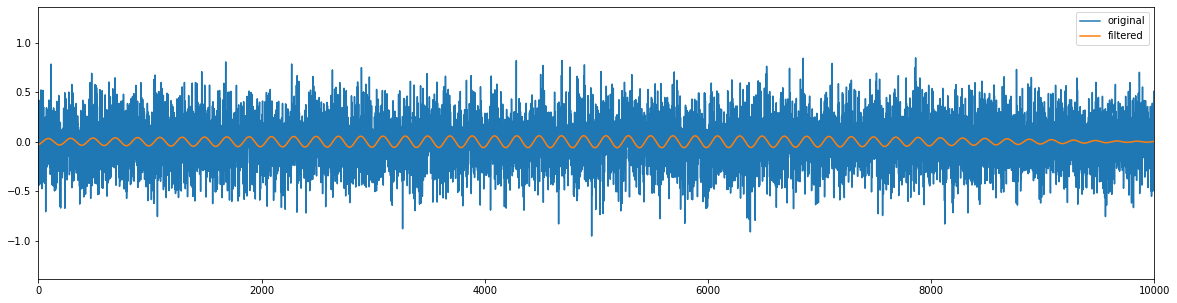

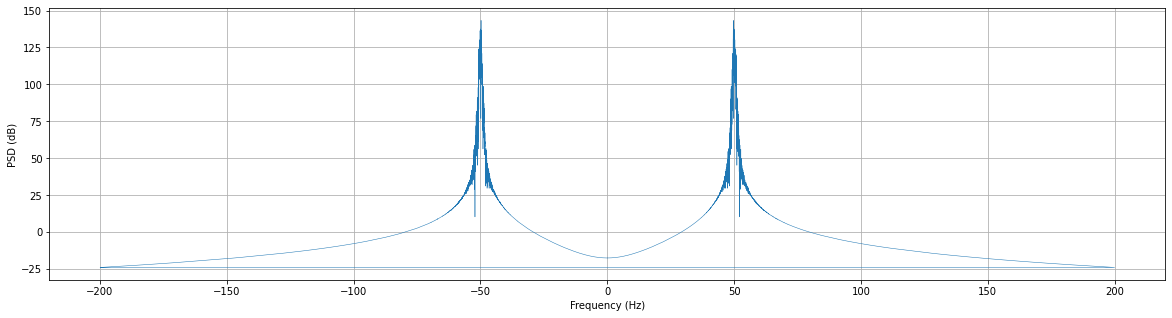

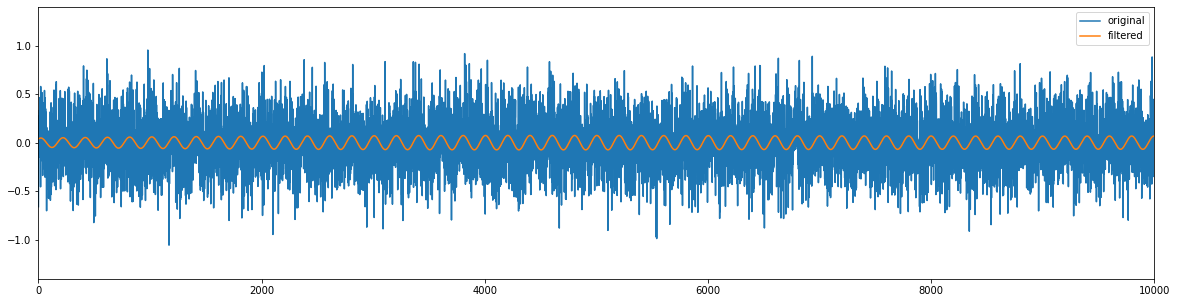

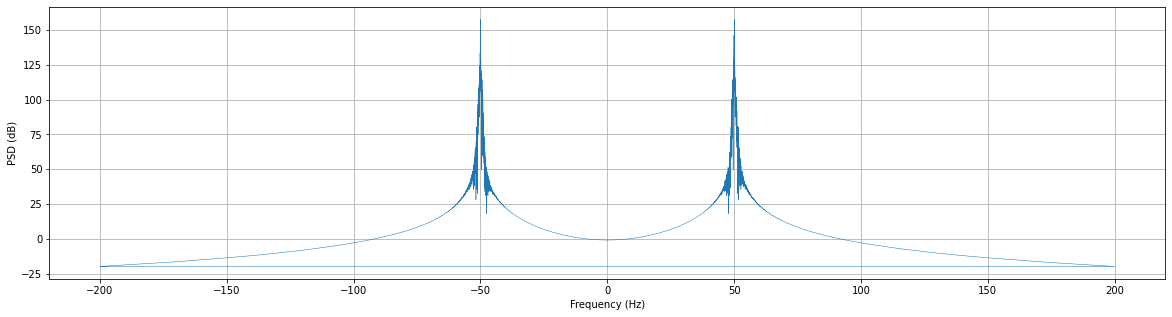

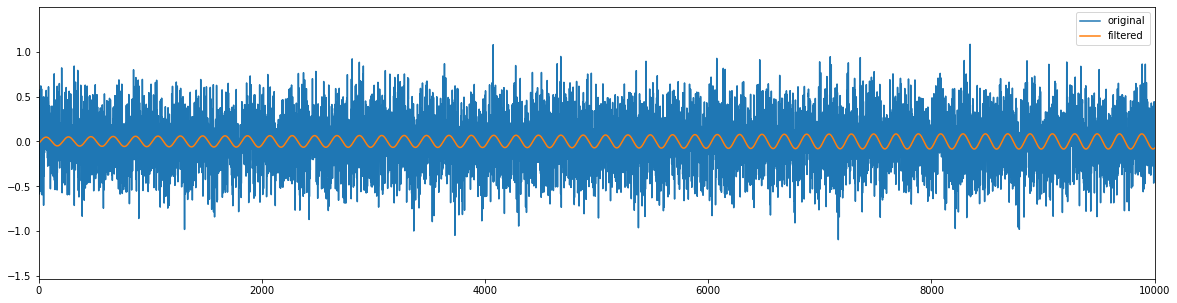

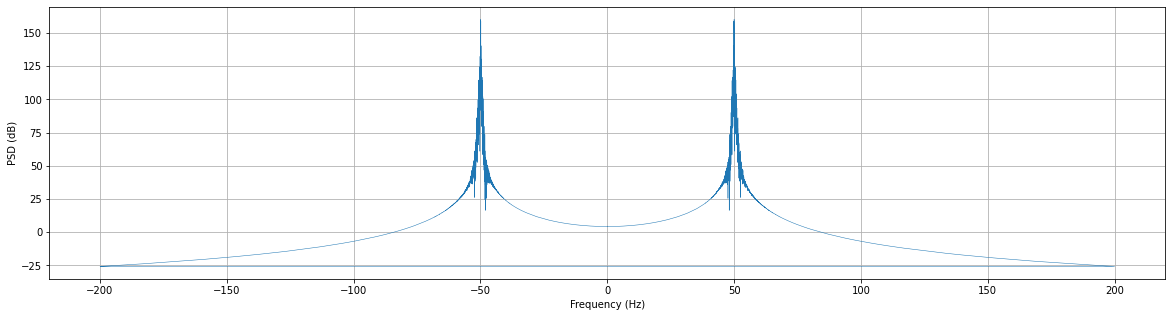

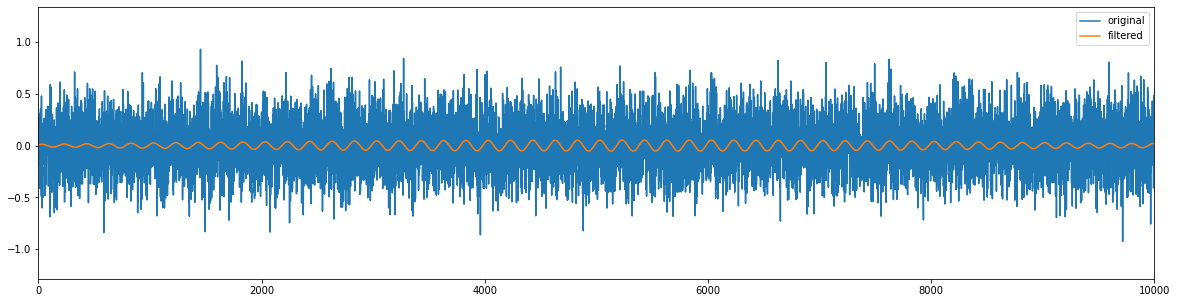

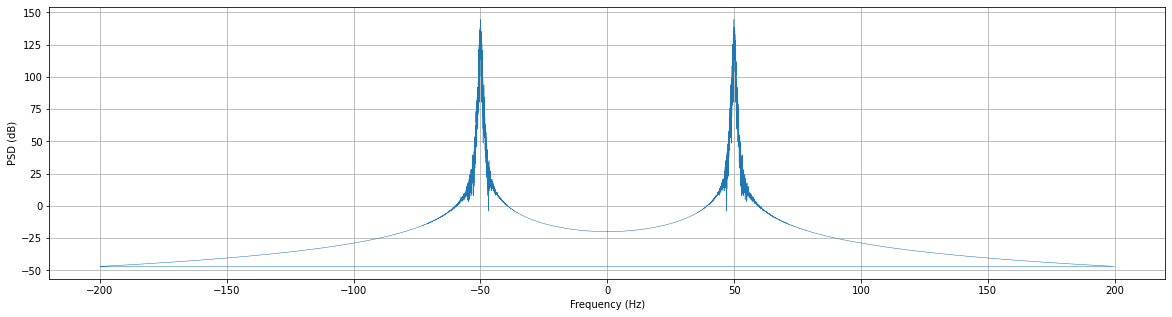

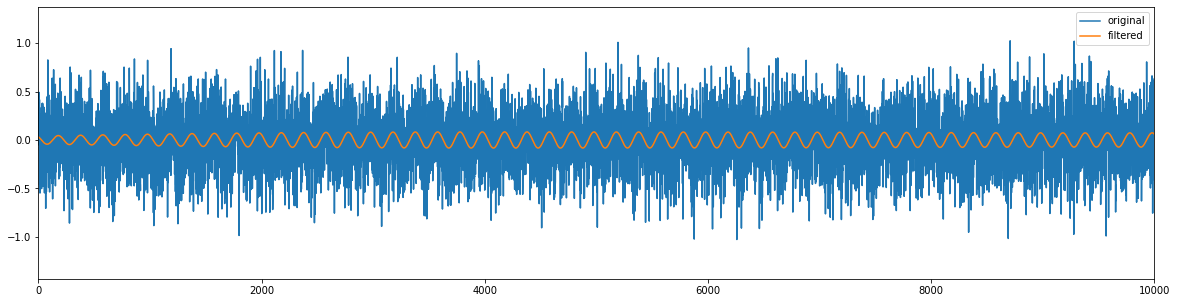

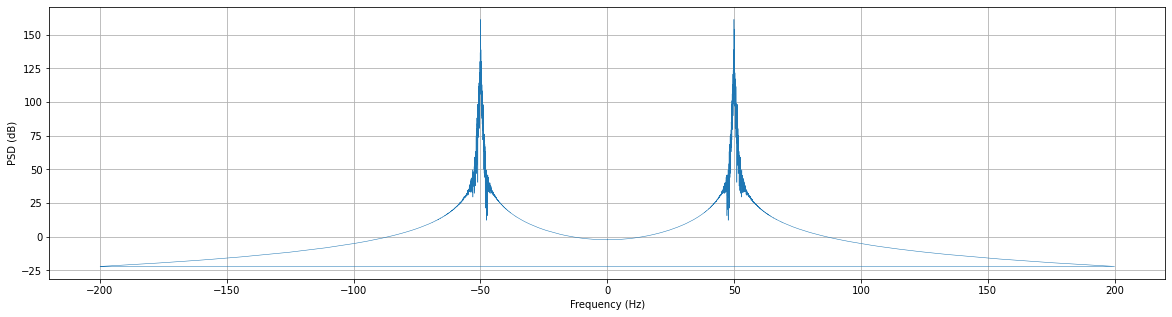

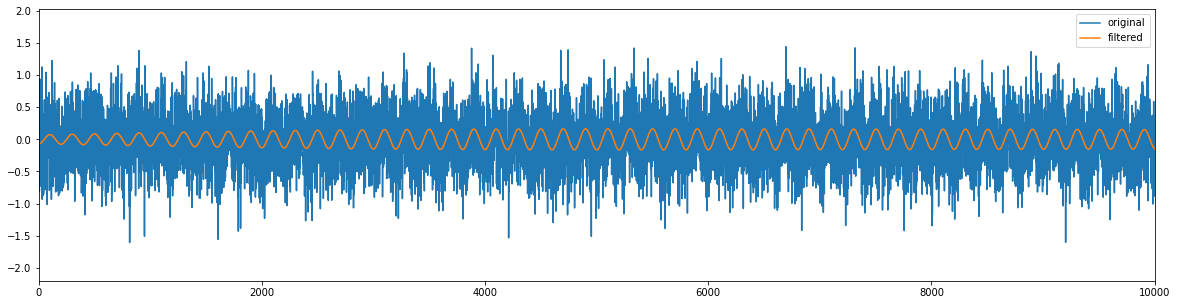

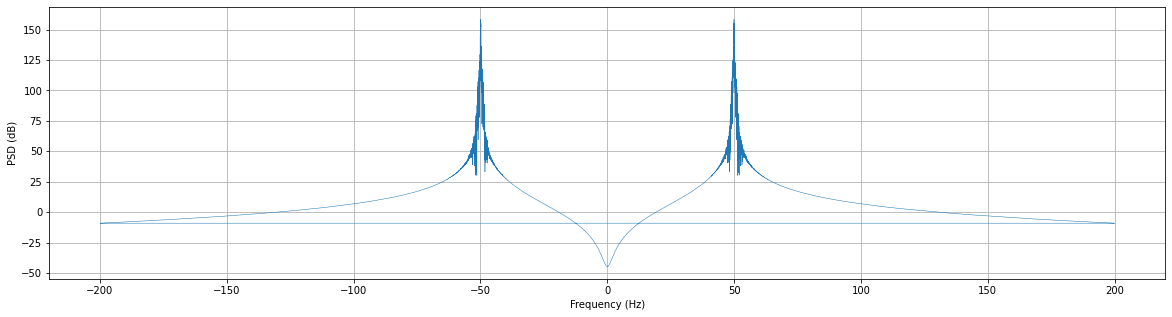

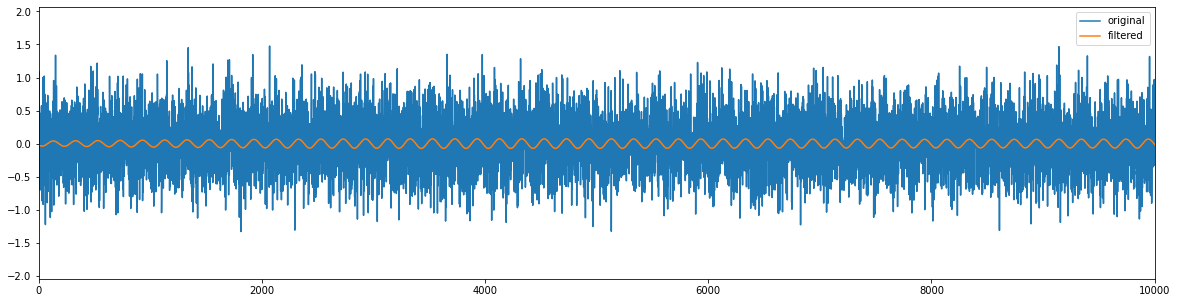

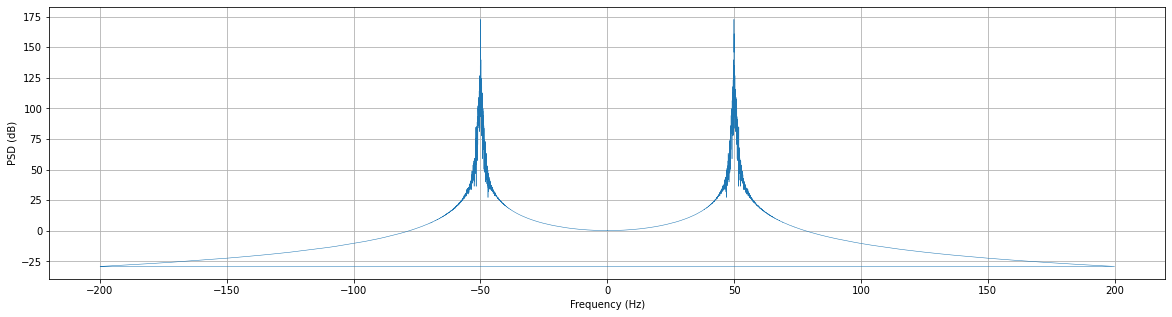

In [15]:
for sig_sample in sig_list:
    sig_remove = bandpass(sig_sample)
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
    fig.subplots_adjust(hspace = .5)
    ax.plot(sig_sample, label = "original")
    ax.plot(sig_remove, label = "filtered")
    ax.legend(loc = "upper right")
    ax.set_xlim(0, 10000)
    plt.show()
    
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
    fig.subplots_adjust(hspace = .5)
    fft = np.fft.fft(sig_remove)
    psd = np.abs(fft) ** 2
    fftfreq = np.fft.fftfreq(len(psd),1/fs)   
    i = abs(fftfreq) < 200
    ax.grid()
    ax.plot(fftfreq[i], 20*np.log10(psd[i]), linewidth=.5)
    ax.set_xlabel('Frequency (Hz)') 
    ax.set_ylabel('PSD (dB)')
    plt.show()